# Data Exploratory Notebook
### Rhea Soil Nutrient Prediction Challenge

Start here:

Looking at distribution of train & test data
* location
* depth
* soil nutrients


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import os

from src.config import DATA_DIR, ZINDI_DATA_DIR

In [8]:
train_df = pd.read_csv(os.path.join(ZINDI_DATA_DIR, "Train.csv"))
test_df = pd.read_csv(os.path.join(ZINDI_DATA_DIR, "TestSet.csv"))
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Column names: {train_df.columns}")

# merge dfs
train_df["dataset"] = "train"
test_df["dataset"] = "test"
df = pd.concat([train_df, test_df]).reset_index()

Train data shape: (44298, 25)
Test data shape: (6070, 17)
Column names: Index(['ID', 'Longitude', 'Latitude', 'start_date', 'end_date',
       'horizon_lower', 'horizon_upper', 'Depth_cm', 'Al', 'B', 'Ca',
       'C_organic', 'C_total', 'Cu', 'electrical_conductivity', 'Fe', 'Mg',
       'Mn', 'N', 'ph', 'P', 'K', 'Na', 'S', 'Zn'],
      dtype='str')


## Geographic distribution & measurement depth

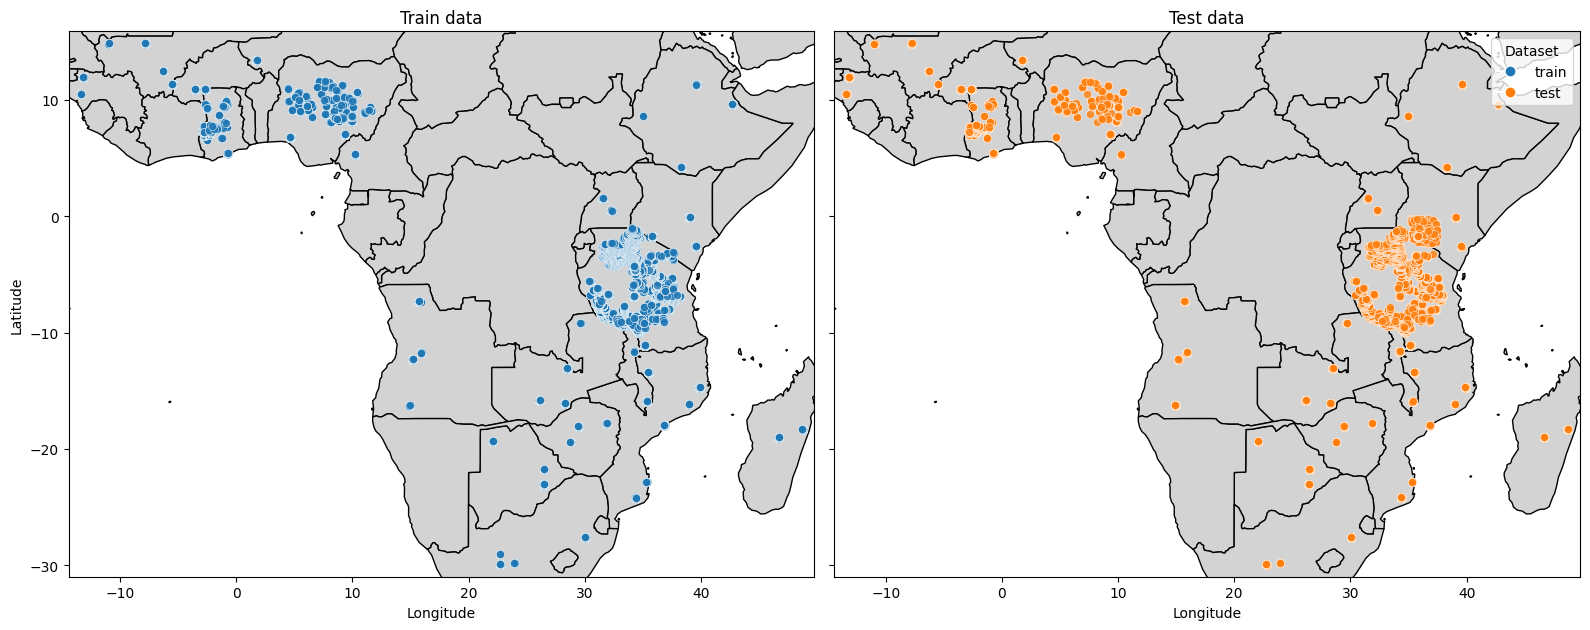

In [24]:
uniq_depths = df.Depth_cm.unique()

world_img = gpd.read_file(
    os.path.join(DATA_DIR, "maps", "global_map", "CNTR_RG_20M_2024_4326.shp")
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

datasets = ["train", "test"]
colors = {"train": "tab:blue", "test": "tab:orange"}

for ax, dataset in zip(axes, datasets):
    # base map
    world_img.plot(ax=ax, color="lightgrey", edgecolor="black")

    ax.set_xlim(df["Longitude"].min() - 1, df["Longitude"].max() + 1)
    ax.set_ylim(df["Latitude"].min() - 1, df["Latitude"].max() + 1)

    for depth in uniq_depths:
        mask = (df.Depth_cm == depth) & (df["dataset"] == dataset)
        ax.scatter(
            df.loc[mask, "Longitude"],
            df.loc[mask, "Latitude"],
            s=35,
            alpha=0.8,
            color=colors[dataset],
            edgecolor="white",
            linewidth=0.4,
        )

    ax.set_title(f"{dataset.capitalize()} data")
    ax.set_xlabel("Longitude")

axes[0].set_ylabel("Latitude")

# legend for dataset (color)
legend_dataset = [
    Line2D([0], [0], marker="o", color="w",
           label=label, markerfacecolor=color, markersize=8)
    for label, color in colors.items()
]

axes[1].legend(handles=legend_dataset, title="Dataset", loc="upper right")

plt.tight_layout()
plt.show()


In [25]:
df.groupby(["Depth_cm", "dataset"]).size()

Depth_cm  dataset
0-20      test        3795
          train      24078
20-50     test        2275
          train      20220
dtype: int64

Both location and soil depth have very similar distributions across the two dataset.